**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [11]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
!pip install scikit-video
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?
        
        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

During the learning phasis, the function act can return 2 types of action : 
1) an action via the policy of the agent (via learned_act function)
2) a random action 

The probabilities of these actions are respectively 1-epsilon and epsilon.
Epsilon is essential because it represents the degree of "randomness" for the actions of the agent.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))
        


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        
        
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        
    
        
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b
        

    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))
        

        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=1000
temperature=0.3
epochs_train=31 # set small when debugging
epochs_test=15 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The array position shows the grid with the positions of the borders (marked with "-1") and the position of the rat([self.x,self.y] marked with "1"). I guess it is useful to avoid that the rat goes out the board limits. 
The array board represents the object which will be graphically displayed. It means that it contains the malus (poison) and the bonus (cheese). It will help to compute the reward after each move (act function). 


## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        action=np.random.randint(4)
        
        return(action)
    

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        ##### FILL IN HERE
        state = env.reset()
    # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.learned_act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
                
        # Save as a mp4
        if e%10==0:
          
          env.draw(prefix+str(e))
        
        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [18]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')

HTML(display_videos('random10.mp4'))

Win/lose count 18.5/36.0. Average score (-17.5)
Win/lose count 24.0/36.0. Average score (-14.75)
Win/lose count 25.0/24.0. Average score (-9.5)
Win/lose count 22.5/21.0. Average score (-6.75)
Win/lose count 24.5/25.0. Average score (-5.5)
Win/lose count 26.0/27.0. Average score (-4.75)
Win/lose count 21.5/33.0. Average score (-5.714285714285714)
Win/lose count 25.5/27.0. Average score (-5.1875)
Win/lose count 20.0/33.0. Average score (-6.055555555555555)
Win/lose count 21.5/27.0. Average score (-6.0)
Win/lose count 19.0/28.0. Average score (-6.2727272727272725)
Win/lose count 26.0/23.0. Average score (-5.5)
Win/lose count 25.0/34.0. Average score (-5.769230769230769)
Win/lose count 24.5/32.0. Average score (-5.892857142857143)
Win/lose count 18.0/38.0. Average score (-6.833333333333333)
Final score: -6.833333333333333


This game shows the move randomness when there is no policy. The score is also bad.

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
import random
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()
        
    def remember(self, m):
        self.memory.append(m)
        pass

    def random_access(self,n):
        return(random.sample(self.memory,n))
        

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            
            action = agent.act(state,train=True)
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)
            

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
            
            

            # Apply the reinforcement strategy
            
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:

class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        s=np.reshape(s,(1,5,5,self.n_state))
        action=np.argmax(self.model.predict(s))
        return(action)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        if len(agent.memory.memory) < agent.batch_size:
            return
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        acc=self.memory.random_access(self.batch_size)   #access to a 32-elements list from memory
        
        target_q = np.zeros((self.batch_size, 4))
        
        
        for i in range(self.batch_size):
            ######## FILL IN
            
            state_t = acc[i][0]
            state_t1 = acc[i][1]
            action_t = acc[i][2]   
            reward_t = acc[i][3]
            game_over_ = acc[i][4]
            
            
            input_states[i:i+1] = state_t
            state_t=np.reshape(state_t,(1,5,5,self.n_state))
            state_t1=np.reshape(state_t1,(1,5,5,self.n_state))
            
            target_q[i] = self.model.predict(state_t)
            Q_sa = np.max(self.model.predict(state_t1))
            
            if game_over_:
                ######## FILL IN
                target_q[i, action_t] = reward_t
            else:
                ######## FILL IN
                target_q[i, action_t] = reward_t +self.discount* Q_sa
        
        #print(target_q)
                
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        
        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        model = Sequential()
        
        #model.add(Dense(32))
        model.add(Reshape((25*self.n_state, ), input_shape=(5,5,self.n_state)))
        #model.add(Dense(32, input_shape=(5,5,2), activation='relu'))
        model.add(Dense(32))
        #model.add(Conv2D(32, 5, 5, input_shape=(5, 5, 2)))
        model.add(Activation('relu'))
       
        model.add(Dense(4))

        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

In [35]:
import h5py
from importlib import reload
reload(keras.models)
env = Environment(grid_size=size, max_time=500, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 64)
train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train30.mp4'))

Epoch 000/031 | Loss 0.0027 | Win/lose count 5.0/6.0 (-1.0)
Epoch 001/031 | Loss 0.0489 | Win/lose count 4.5/7.0 (-2.5)
Epoch 002/031 | Loss 0.0034 | Win/lose count 1.0/1.0 (0.0)
Epoch 003/031 | Loss 0.0013 | Win/lose count 4.5/5.0 (-0.5)
Epoch 004/031 | Loss 0.0014 | Win/lose count 4.0/2.0 (2.0)
Epoch 005/031 | Loss 0.0011 | Win/lose count 0.5/3.0 (-2.5)
Epoch 006/031 | Loss 0.0023 | Win/lose count 6.0/0 (6.0)
Epoch 007/031 | Loss 0.0373 | Win/lose count 6.0/5.0 (1.0)
Epoch 008/031 | Loss 0.0045 | Win/lose count 3.0/4.0 (-1.0)
Epoch 009/031 | Loss 0.0019 | Win/lose count 3.0/3.0 (0.0)
Epoch 010/031 | Loss 0.0055 | Win/lose count 1.5/0 (1.5)
Epoch 011/031 | Loss 0.0048 | Win/lose count 3.5/5.0 (-1.5)
Epoch 012/031 | Loss 0.0032 | Win/lose count 8.0/1.0 (7.0)
Epoch 013/031 | Loss 0.0029 | Win/lose count 5.0/3.0 (2.0)
Epoch 014/031 | Loss 0.0024 | Win/lose count 9.5/7.0 (2.5)
Epoch 015/031 | Loss 0.0051 | Win/lose count 3.5/1.0 (2.5)
Epoch 016/031 | Loss 0.0024 | Win/lose count 9.0/9.0 (

Many parameters have been tested for the model. Finally we keep the following ones: 
learning rate=0.3, memory=2000, batch_size=32

After 10 epochs, the model becomes more stable.

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        model=Sequential()
        model.add(Conv2D(16, kernel_size=2, input_shape=(5, 5, self.n_state)))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Reshape((64, ), input_shape=(2,2,16)))
        
        model.add(Dense(4))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [33]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 64)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train30.mp4'))

Epoch 000/031 | Loss 0.0015 | Win/lose count 3.0/6.0 (-3.0)
Epoch 001/031 | Loss 0.0105 | Win/lose count 11.5/5.0 (6.5)
Epoch 002/031 | Loss 0.0020 | Win/lose count 5.5/6.0 (-0.5)
Epoch 003/031 | Loss 0.0021 | Win/lose count 9.0/9.0 (0.0)
Epoch 004/031 | Loss 0.0094 | Win/lose count 8.5/6.0 (2.5)
Epoch 005/031 | Loss 0.0028 | Win/lose count 4.5/10.0 (-5.5)
Epoch 006/031 | Loss 0.0291 | Win/lose count 2.0/9.0 (-7.0)
Epoch 007/031 | Loss 0.0048 | Win/lose count 8.0/4.0 (4.0)
Epoch 008/031 | Loss 0.0020 | Win/lose count 4.5/4.0 (0.5)
Epoch 009/031 | Loss 0.0012 | Win/lose count 5.0/5.0 (0.0)
Epoch 010/031 | Loss 0.0005 | Win/lose count 4.0/9.0 (-5.0)
Epoch 011/031 | Loss 0.0005 | Win/lose count 6.0/3.0 (3.0)
Epoch 012/031 | Loss 0.0036 | Win/lose count 7.0/13.0 (-6.0)
Epoch 013/031 | Loss 0.0014 | Win/lose count 5.0/9.0 (-4.0)
Epoch 014/031 | Loss 0.0050 | Win/lose count 10.0/5.0 (5.0)
Epoch 015/031 | Loss 0.0008 | Win/lose count 10.5/7.0 (3.5)
Epoch 016/031 | Loss 0.0043 | Win/lose count

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [37]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 64)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 64)
agent_fc.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 0.5/0. Average score (0.5)
Win/lose count 7.0/2.0. Average score (2.75)
Win/lose count 0/0. Average score (1.8333333333333333)
Win/lose count 1.0/0. Average score (1.625)
Win/lose count 2.5/2.0. Average score (1.4)
Win/lose count 1.5/0. Average score (1.4166666666666667)
Win/lose count 5.5/2.0. Average score (1.7142857142857142)
Win/lose count 2.5/0. Average score (1.8125)
Win/lose count 1.0/2.0. Average score (1.5)
Win/lose count 4.0/1.0. Average score (1.65)
Win/lose count 2.0/1.0. Average score (1.5909090909090908)
Win/lose count 0.5/1.0. Average score (1.4166666666666667)
Win/lose count 2.0/1.0. Average score (1.3846153846153846)
Win/lose count 0/0. Average score (1.2857142857142858)
Win/lose count 4.5/0. Average score (1.5)
Final score: 1.5
Test of the FC
Win/lose count 4.5/1.0. Average score (3.5)
Win/lose count 1.5/0. Average score (2.5)
Win/lose count 4.0/0. Average score (3.0)
Win/lose count 0/0. Average score (2.25)
Win/lose count 1.0/0. Average

The results seem better for the CNN model. However the results are quite disappointing regarding the average score.

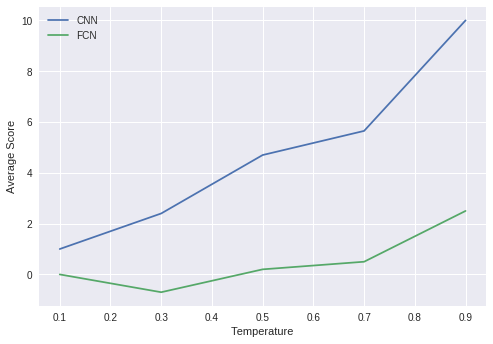

In [26]:
import matplotlib.pyplot as plt
x=[0.1,0.3,0.5,0.7,0.9]
y_cnn=[1,2.4,4.7,5.65,10]
y_fc=[0,-0.7,0.2,0.5,2.5]
plt.plot(x,y_cnn)

plt.plot(x,y_fc)
plt.legend(['CNN','FCN'])
plt.ylabel('Average Score')
plt.xlabel('Temperature')
plt.show()

In [38]:
HTML(display_videos('cnn_test10.mp4'))

In [39]:
HTML(display_videos('fc_test10.mp4'))

We can see the linear relation between temperature and average temperature. 
The main issue of our model is that the rat "play safe", that is to say it prefer to stay at the same little space (two or three cells) instead of moving and exploring the entire grid.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:

def train_explore(agent,env,epoch,prefix=''):
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        win = 0
        lose = 0
        epsilon=agent.epsilon
        while not game_over:
            
            # The agent performs an action
            action = agent.act(state)

            
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)
            

            # Update the counters
            if reward > 0:
                win = win + reward
                   
            if reward < 0:
                lose = lose -reward
                agent.set_epsilon(epsilon*0.95)  #here we have the decreasing ϵ -greedy exploration
            

            # Apply the reinforcement strategy
            
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    pass
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        pass
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1
        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        self.malus_position[self.x,self.y]=0.1
        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))
        


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        
        
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        
    
        
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b
        

    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        reward += self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        
        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        self.malus_position[self.x,self.y]=0.1
        
        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))
        

        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        
        
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state




Each time the rat eats a malus, the epsilon decreases. It means that there will be less "random" moves and less exploration. 

In [41]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.5, memory_size=2000, batch_size = 64,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

Epoch 000/031 | Loss 0.0069 | Win/lose count 15.0/104.9999999999982 (-89.9999999999982)
Epoch 001/031 | Loss 0.0040 | Win/lose count 13.5/100.39999999999857 (-86.89999999999857)
Epoch 002/031 | Loss 0.0026 | Win/lose count 19.5/105.49999999999835 (-85.99999999999835)
Epoch 003/031 | Loss 0.0048 | Win/lose count 13.0/107.4999999999982 (-94.4999999999982)
Epoch 004/031 | Loss 0.0035 | Win/lose count 15.5/113.99999999999784 (-98.49999999999784)
Epoch 005/031 | Loss 0.0033 | Win/lose count 22.0/111.49999999999828 (-89.49999999999828)
Epoch 006/031 | Loss 0.0024 | Win/lose count 27.5/108.69999999999817 (-81.19999999999817)
Epoch 007/031 | Loss 0.0038 | Win/lose count 12.5/109.99999999999804 (-97.49999999999804)
Epoch 008/031 | Loss 0.0031 | Win/lose count 28.5/112.09999999999786 (-83.59999999999786)
Epoch 009/031 | Loss 0.0014 | Win/lose count 19.0/116.49999999999793 (-97.49999999999793)
Epoch 010/031 | Loss 0.0033 | Win/lose count 25.5/114.49999999999798 (-88.99999999999798)
Epoch 011/031 

In [42]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 8.5/100.09999999999859. Average score (-91.59999999999859)
Win/lose count 16.5/100.39999999999857. Average score (-87.74999999999858)
Win/lose count 3.0/100.79999999999855. Average score (-91.09999999999856)
Win/lose count 6.0/99.39999999999863. Average score (-91.67499999999858)
Win/lose count 15.0/99.8999999999986. Average score (-90.31999999999859)
Win/lose count 4.5/98.29999999999869. Average score (-90.8999999999986)
Win/lose count 17.0/101.8999999999985. Average score (-90.04285714285572)
Win/lose count 17.5/96.09999999999881. Average score (-88.6124999999986)
Win/lose count 12.0/99.39999999999863. Average score (-88.47777777777638)
Win/lose count 25.5/96.49999999999879. Average score (-86.72999999999863)
Win/lose count 8.0/100.29999999999858. Average score (-87.23636363636226)
Win/lose count 13.0/101.5999999999985. Average score (-87.3499999999986)
Win/lose count 7.5/102.19999999999847. Average score (-87.9153846153832)
Win/lose count 15.0/96.69999999999878. Avera

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***